In [36]:
import tarfile
import urllib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from kneed import KneeLocator

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler

import netCDF4 as nc
import os
import xarray as xr
from source2 import *

## Data
loading the entired data for 3+ months in 2021. The data is resample by the hour per day and store in a single data frame

In [4]:
fixed_p='/Users/jenifervivar/Desktop/NERTO_2022/Lidar_Data/Vertical_data/'
columns = (np.array([i for i in range(200, 5200, 100)]))
#Montly data frames
dfCnr = pd.DataFrame()
dfBeta = pd.DataFrame()
dfSpectral= pd.DataFrame()
dfWind = pd.DataFrame()
for folder in sorted(os.listdir(fixed_p))[1:-1]:
    
    date = folder[3:]

    #collects and puts together the data for the whole day
    path = fixed_p + folder + '/'
    variables = VAREXTRACT(path)
    variables.extract()
    cnr_ = variables.cnr_day
    time = pd.to_datetime(variables.time_day, unit = 's', utc = True)
    wind = variables.ver_wind_speed 
    spect_width = variables.spectral_width_day
    beta = variables.relat_beta_day 
    #daily dataframes
    df_cnr =dataframe_set(cnr_, time, date).resample('30T').mean()


    df_beta = dataframe_set(beta, time, date).resample('30T').mean()

    df_spectralWidth = dataframe_set(spect_width, time, date).resample('30T').mean()


    df_wind = dataframe_set(wind, time, date).resample('30T').mean()


    #concatanating to all DF
    dfCnr =pd.concat([dfCnr, df_cnr], axis =0)
    dfBeta = pd.concat([dfBeta, df_beta], axis = 0)
    dfSpectral = pd.concat([dfSpectral, df_spectralWidth], axis = 0)
    dfWind = pd.concat([dfWind, df_wind], axis =0)

   
   
print(dfCnr.head())    

                                5100       5000       4900       4800  \
2021-07-17 00:00:00+00:00 -32.995361 -32.936528 -32.939083 -32.864194   
2021-07-17 00:30:00+00:00 -32.950597 -32.808056 -32.747778 -32.869667   
2021-07-17 01:00:00+00:00 -32.934972 -32.858819 -32.924639 -32.885944   
2021-07-17 01:30:00+00:00 -32.821958 -32.801569 -32.700819 -32.992014   
2021-07-17 02:00:00+00:00 -32.970403 -32.850944 -32.807125 -32.968542   

                                4700       4600       4500       4400  \
2021-07-17 00:00:00+00:00 -32.915903 -32.850806 -32.767403 -32.939292   
2021-07-17 00:30:00+00:00 -32.776847 -32.826472 -32.673167 -32.475278   
2021-07-17 01:00:00+00:00 -32.926597 -32.936097 -32.913792 -32.849167   
2021-07-17 01:30:00+00:00 -32.817306 -32.926931 -32.854486 -32.870181   
2021-07-17 02:00:00+00:00 -32.872375 -32.875569 -32.888625 -32.848111   

                                4300       4200  ...      1100      1000  \
2021-07-17 00:00:00+00:00 -32.837986 -32.87608

In [ ]:
for folder in sorted(os.listdir(fixed_p))[1:-1]:
    df_atm= variables.atm_structures
    date = folder[3:]

## Feature reduction
I would like to only get the most relevant features of each data frame. Each data frame is specific to wind, cnr, etc. The goal is to have all these important values combined in a data frame

In [72]:
def reducer(df, n_features = 2):
    scaler = StandardScaler()
    std_df = scaler.fit_transform(df)
    pca = PCA(n_features)
    x = pca.fit_transform(std_df)
    var= pca.explained_variance_ratio_
    return x, var

In [73]:
cnr,v = reducer(dfCnr)
wind, v_1 = reducer(dfWind)
beta, v_2 = reducer(dfBeta)
espWidth, v_3 = reducer(dfSpectral)

In [75]:
print(v, v_1, v_2, v_3)

[0.4342472  0.14335553] [0.42302862 0.13255782] [0.07341627 0.06189504] [0.53298992 0.18657582]


In [76]:
#creating a new data frame
data = {"cnr_1":cnr[:,0], "cnr_2": cnr[:,1], "wind_1":wind[:,0], "wind_2": wind[:,1], "espcW_1": espWidth[:,0], "espcW_2":espWidth[:,1]}
all_df = pd.DataFrame(data, index = dfCnr.index)

In [77]:
all_df.head(-5)

,cnr_1,cnr_2,wind_1,wind_2,espcW_1,espcW_2
2021-07-17 00:00:00+00:00,-1.458422,-2.862206,3.525198,-1.286315,3.587168,-0.723631
2021-07-17 00:30:00+00:00,-1.943114,-1.684626,3.818009,-0.788940,3.620742,-0.086824
2021-07-17 01:00:00+00:00,-2.306523,-1.898777,5.398853,-2.176903,4.321054,0.720427
2021-07-17 01:30:00+00:00,-2.477225,-1.476225,3.723760,-1.663105,4.449993,1.148632
2021-07-17 02:00:00+00:00,-2.139009,-2.038531,4.629435,-1.282560,3.879742,0.090045
...,...,...,...,...,...,...
2021-10-13 19:00:00+00:00,-5.218520,1.632521,7.346085,1.877037,5.606728,1.914751
2021-10-13 19:30:00+00:00,-4.956671,1.317448,3.258682,-0.395840,4.505535,1.293525
2021-10-13 20:00:00+00:00,-3.355486,-0.403054,1.275363,-4.160520,0.899788,-2.114303
2021-10-13 20:30:00+00:00,-3.519191,-0.030294,0.318713,-3.181262,0.969858,-2.699205


In [ ]:
all_x = 

In [60]:
std_cnr = scaler.fit_transform(dfCnr)

pca = PCA(3)
cnr_ = pca.fit_transform(std_cnr)

In [66]:
pca.singular_values_

array([299.99621996, 172.3671487 , 127.82005913])

In [24]:
#standarizing the data and reducing the amount of inputs I need
scaler = StandardScaler()
std_df = scaler.fit_transform(dfWind)
print(std_df)
pca = PCA(3)
w = pca.fit_transform(std_df)
print(x, type(x))

[[-1.00428912  0.0349553  -0.16032411 ... -0.0600047  -0.09583175
  -0.2036817 ]
 [-0.80180854  0.4949375  -0.7870842  ... -0.21312412 -0.01197973
   0.50377835]
 [-1.49483692 -0.78052293 -0.98591753 ...  0.63390355  0.59558438
   0.22618039]
 ...
 [-0.70037707 -0.24236373 -1.05122028 ...  0.11435748 -0.00303056
  -0.11069453]
 [-0.12566874 -0.7250921  -1.07547373 ...  0.24176691  0.27826074
   0.19249524]
 [ 0.42322964 -0.75736039 -0.19431119 ...  0.19706663  0.08296443
  -0.01377251]]
[[ 3.52519793 -1.28631532 -2.67869421]
 [ 3.81800945 -0.78893969 -3.01149553]
 [ 5.39885262 -2.17690257 -3.30048297]
 ...
 [ 1.21402757 -2.97761377 -0.61014663]
 [ 3.74014509 -0.27815347 -0.96144351]
 [ 1.05896727  2.52959759  0.04935323]] <class 'numpy.ndarray'>


In [67]:
#verifying % of data explained by variables
pca.components_

array([[ 0.07359376,  0.08592099,  0.10112059,  0.11197923,  0.11445183,
         0.11461606,  0.12056298,  0.13109987,  0.13839153,  0.14563943,
         0.15102525,  0.15687975,  0.16239745,  0.16320277,  0.16243734,
         0.16497928,  0.16809322,  0.16918528,  0.16995636,  0.1736489 ,
         0.17651963,  0.17794425,  0.17954501,  0.18020645,  0.17801706,
         0.17773405,  0.17356786,  0.16523137,  0.16291373,  0.16494741,
         0.16497168,  0.165476  ,  0.16445651,  0.15901889,  0.15517098,
         0.15455714,  0.15427565,  0.15106905,  0.14451842,  0.13645326,
         0.12633215,  0.11087821,  0.09237342,  0.07479728,  0.05076693,
         0.02280779, -0.00114868, -0.03654947, -0.05868712, -0.0537661 ],
       [ 0.12796883,  0.15297869,  0.18164904,  0.19901989,  0.20494655,
         0.20820987,  0.20867317,  0.20935493,  0.19818429,  0.19405673,
         0.18808992,  0.17677619,  0.1635277 ,  0.14660002,  0.12840446,
         0.11387687,  0.09617713,  0.07679273,  0.

In [33]:
sse = []
for k in range(2, 11):
    kmeans = KMeans(k)
    kmeans.fit(x)
    sse.append(kmeans.inertia_)

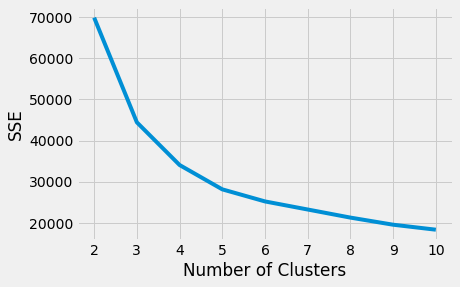

In [35]:
#plotting the sum of squares distances to get ideal k value
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [37]:
kl = KneeLocator(
range(2, 11), sse, curve="convex", direction="decreasing")

kl.elbow

4

In [48]:
kmeans = KMeans(5)
identified_custers = kmeans.fit_predict(x)
identified_custers

array([1, 1, 1, ..., 2, 1, 1], dtype=int32)

In [41]:
x[:,0]

array([3.52519793, 3.81800945, 5.39885262, ..., 1.21402757, 3.74014509,
       1.05896727])

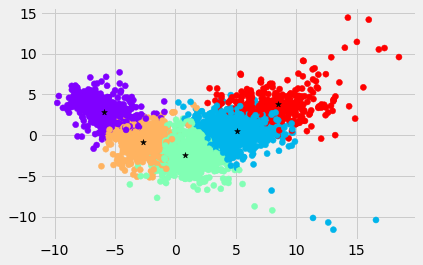

In [51]:
plt.scatter(x[:,0],x[:,1],c=identified_custers,cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker = '*', c  = 'black')
plt.show()

## Kmeans pipeline

In [9]:
preprocessor = Pipeline([("scaler",  StandardScaler()), ("pca", PCA(n_components=2, random_state=42)),])

In [10]:
clusterer = Pipeline([("kmeans",KMeans(n_clusters=10,init="k-means++",n_init=50,max_iter=500,random_state=42,),),])

In [11]:
pipe = Pipeline([("preprocessor", preprocessor),("clusterer", clusterer)])